In [104]:
import numpy as np
import pandas as pd
import re
import nltk
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense,Input,Dropout,Embedding,LSTM
from time import time
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
import  matplotlib.pyplot as plt

In [53]:
with open("Flickr_TextData/Flickr8k.token.txt") as f:
    captions = f.read()

In [54]:
captions = captions.split("\n")[:-1]

In [55]:
len(captions)
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [56]:
descriptions = {}

for element in captions:
    i_to_c = element.split("\t")
    cap = i_to_c[1]
    
    key = i_to_c[0].split(".")[0]
    
    if descriptions.get(key) == None:
        descriptions[key] = []
        
    descriptions[key].append(cap)

In [57]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Data Cleaning

In [58]:
"""
1. lower
2. remove puntuations
3. remove words less than length 2
"""

def clean_text(sample):
    sample = sample.lower()
    sample = re.sub("[^a-z]+"," ", sample)
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample


In [59]:
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        descriptions[key][i] = clean_text(desc_list[i])

In [60]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [61]:
# create unique vocabulary

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]
    
print(len(vocabulary))

8424


In [62]:
all_vocab = []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]
    
print(len(all_vocab))

373837


In [63]:
import collections

In [64]:
counter = collections.Counter(all_vocab)

In [65]:
dict_ = dict(counter)

In [66]:
sorted_dic = sorted(dict_.items(),reverse=True,key = lambda x : x[1])
threshhold_val = 10
sorted_dic = [x for x in sorted_dic if x[1]>threshhold_val]
vocabulary = [x[0] for x in sorted_dic]

In [67]:
len(vocabulary)

1845

# Load Training Testing Data

In [68]:
with open("Flickr_TextData/Flickr_8k.trainImages.txt") as f:
    train = f.read()
with open("Flickr_TextData/Flickr_8k.testImages.txt") as f:
    test = f.read()

In [69]:
train = [e.split(".")[0] for e in train.split("\n")[:-1]]
test = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [70]:
train_descriptions = {}
for t in train:
    train_descriptions[t] = []
    
    for cap in descriptions[t]:
        cap_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_append)

In [71]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Data Preprocessing

In [72]:
model = ResNet50(weights = "imagenet",input_shape=(224,224,3))

In [73]:
model_new = Model(inputs = model.input,outputs=model.layers[-2].output)

In [74]:
images = "flickr_data/Flickr_Data/Images/"

In [75]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    
    return img

In [76]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img).reshape((2048,))
    return feature_vector

In [77]:
x = encode_image(images+"/1000268201_693b08cb0e.jpg")

In [78]:
x.shape

(2048,)

In [28]:
start = time()

encoding_train = {}

for ix,img_ in enumerate(train):
    
    img = images+img_+".jpg"
    
    encoding_train[img] = encode_image(img)
    
    if ix%100 ==0:
        print("encoding image "+str(ix),end="\r")
    


In [29]:
# writing pkl file on disk
with open("encoded_train_images.pkl", "wb") as p:
    pickle.dump(encoding_train,p)

In [79]:
#reading pkl file from disk
with open("encoded_train_images.pkl", "rb") as p:
    encoding_train = pickle.load(p)

In [31]:
start = time()

encoding_test = {}

for ix,img_ in enumerate(test):
    
    img = images+img_+".jpg"
    
    encoding_test[img] = encode_image(img)
    
    if ix%100 ==0:
        print("encoding image "+str(ix),end="\r")
    


In [32]:
# writing pkl file on disk
with open("encoded_test_images.pkl", "wb") as p:
    pickle.dump(encoding_test,p)

In [80]:
#reading pkl file from disk
with open("encoded_test_images.pkl", "rb") as p:
    encoding_test = pickle.load(p)

# Data Preprocessing Captions

In [81]:
# Mapping word_to_idx and idx_to_word

ix = 1
word_to_idx = {}
idx_to_word = {}

for e in vocabulary:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix+=1

In [82]:
word_to_idx['dog']

6

In [83]:
idx_to_word[1846] = "startseq"
word_to_idx["startseq"] = 1846

idx_to_word[1847] = "endseq"
word_to_idx["endseq"] = 1847

In [84]:
vocab_size = len(idx_to_word) +1
print(vocab_size)

1848


In [85]:
all_caption_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_caption_len.append(len(cap.split()))
        
max_len = max(all_caption_len)
print(max_len)

35


## Data Prepare using Generator

In [86]:
def data_generator(train_descriptions,encoding_train,word_to_idx, max_len,num_photos_per_batch):
    x1,x2,y = [],[],[]
    n=0
    while True:
        for key, desc_list in train_descriptions.items():
            n+=1
            photo = encoding_train[images+key+".jpg"]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq],maxlen=max_len,value=0,padding="post")[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[np.array(x1),np.array(x2)],np.array(y)]
                x1,x2,y =[],[],[]
                n=0
                

# Word Embedding

In [87]:
with open("glove.6B.50d.txt",encoding="utf8") as f:
    embedding_index={}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype="float")
        embedding_index[word] = coefs

In [88]:
def get_embedding_output():
    em_dim = 50
    
    embedding_output = np.zeros((vocab_size, em_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
    return embedding_output

In [89]:
embedding_output = get_embedding_output()

In [90]:
embedding_output.shape

(1848, 50)

In [91]:
print(embedding_output)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.33042   0.24995  -0.60874  ... -0.50703  -0.027273 -0.53285 ]
 [ 0.418     0.24968  -0.41242  ... -0.18411  -0.11514  -0.78581 ]
 ...
 [-0.34126  -0.06117   0.93339  ... -0.5682   -0.6244    0.30874 ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


# Model Arch

In [92]:
# image feature extractor model
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation="relu")(inp_img1)

In [93]:
# partial caption sequence model
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


In [94]:
# combining both models

decoder = add([inp_img2,inp_cap3])
decoder1 = Dense(256,activation="relu")(decoder)
output = Dense(vocab_size,activation="softmax")(decoder1)

In [95]:
model = Model(inputs = [input_img_fea,inp_cap],outputs = output)

In [96]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [97]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [98]:
model.compile(loss="categorical_crossentropy", optimizer = "adam")

# Training

In [99]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [101]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train,word_to_idx,max_len,number_pics_per_batch)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps)
    model.save("model_"+str(i)+".h5")

Epoch 1/1
2000/2000 [==============================] - 676s 338ms/step - loss: 4.2746
Epoch 1/1
2000/2000 [==============================] - 533s 266ms/step - loss: 3.5822
Epoch 1/1
2000/2000 [==============================] - 486s 243ms/step - loss: 3.3317
Epoch 1/1
2000/2000 [==============================] - 534s 267ms/step - loss: 3.1767
Epoch 1/1
2000/2000 [==============================] - 746s 373ms/step - loss: 3.0662
Epoch 1/1
2000/2000 [==============================] - 714s 357ms/step - loss: 2.9817
Epoch 1/1
2000/2000 [==============================] - 583s 291ms/step - loss: 2.9124
Epoch 1/1
2000/2000 [==============================] - 507s 253ms/step - loss: 2.8578
Epoch 1/1
2000/2000 [==============================] - 498s 249ms/step - loss: 2.8080
Epoch 1/1
2000/2000 [==============================] - 501s 251ms/step - loss: 2.7715


# Prediction

In [102]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

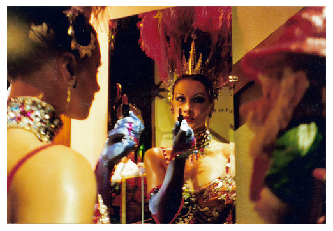

two women in colorful clothing are sitting in front of crowd of people


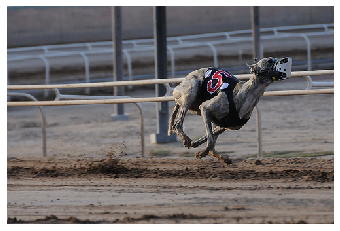

dog is racing around track


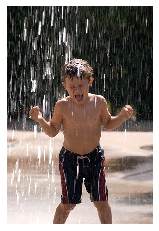

small boy in blue shorts is walking through the water


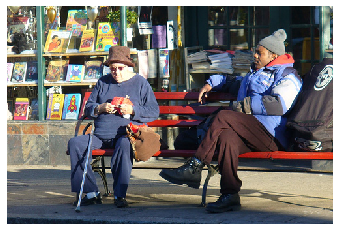

man in black shirt and black hat is sitting on the sidewalk


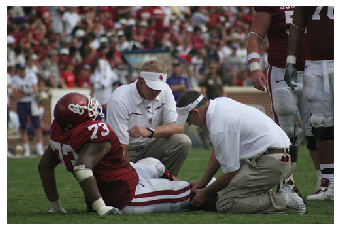

two men in red jerseys are playing football


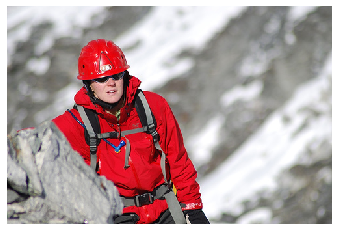

man in red helmet is scaling


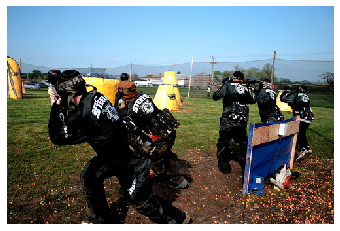

group of people are riding horses on the dirt


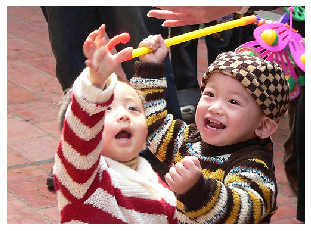

boy in red shirt is playing with toy


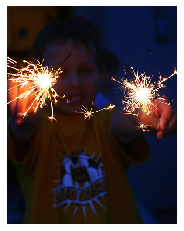

man with tennis racquet is holding up seven seven people


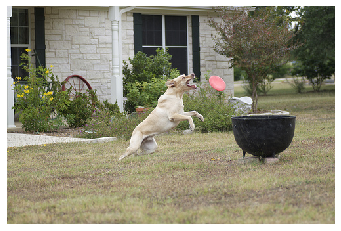

man and woman are walking down dirt road


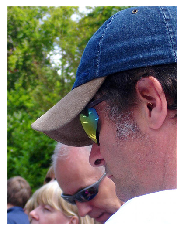

man wearing black shirt and black hardhat with his head on his head


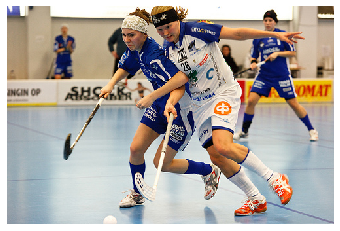

two men in uniforms are playing soccer


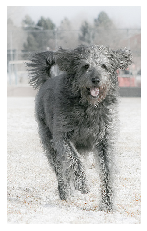

dog running in the snow


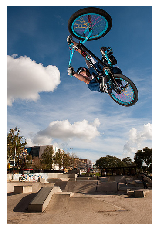

bicyclist performing trick on bike


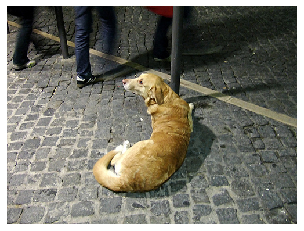

dog is standing on its hind legs in front of some plants


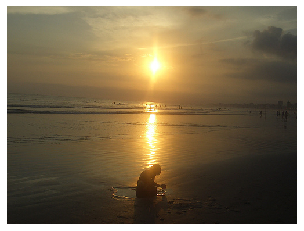

two people are sitting on dock near the water


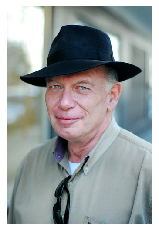

man in black shirt and hat is standing in front of brick wall


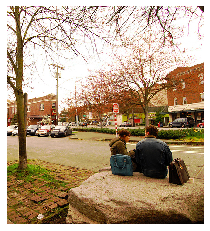

man in black shirt is sitting on bench in front of plant


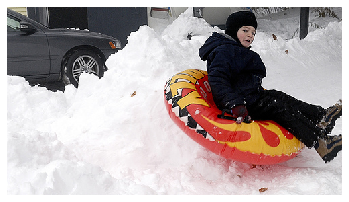

child in red coat is playing with an orange ball in the snow


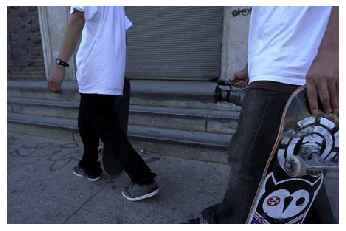

man in black shirt and black shirt is standing in front of brick wall


In [106]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)